In [2]:
import pandas as pd
import numpy as np
from scipy.signal import correlate
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load pieman_segments
pieman_segments = pd.read_csv("pieman_segments.csv")

# Compute row-wise mode of LLM segment indices
segment_cols = [f"segment_idx_{i}" for i in range(6)]
pieman_segments["mode_segment"] = pieman_segments[segment_cols].apply(lambda row: row.mode().iloc[0], axis=1)

# Keep only TR and mode_segment
clean_seg = pieman_segments[["TR", "mode_segment"]].copy()

# Get one row per TR (e.g., first token in TR)
clean_seg = clean_seg.groupby("TR").agg({"mode_segment": "first"}).reset_index()

# Compute segment boundary (no boundary on the first row)
clean_seg["segment_boundary"] = (clean_seg["mode_segment"] != clean_seg["mode_segment"].shift()).astype(int)
clean_seg.loc[0, "segment_boundary"] = 0  # make sure first row is 0

# Create full TR range
full_trs = pd.DataFrame({"TR": range(1, 301)})

# Merge with existing data
clean_seg_full = pd.merge(full_trs, clean_seg, on="TR", how="left")

# Fill missing segment_boundary with 0
clean_seg_full["segment_boundary"] = clean_seg_full["segment_boundary"].fillna(0).astype(int)

# Have ready to feed into cross correlation
event_boundaries = list(clean_seg_full["segment_boundary"])

# Start with segment_boundary as a float list to allow NaNs
event_boundaries = clean_seg_full["segment_boundary"].astype(float).tolist()

event_boundaries = np.array(event_boundaries)

# Set first 13 elements to NaN
event_boundaries[:13] = np.nan

# Set from index 292 to the end to NaN
event_boundaries[292:] = np.nan

# Remove all NaN values
event_boundaries = event_boundaries[~np.isnan(event_boundaries)]

In [4]:
def get_state_transitions(state_vector): # fixed: state_vector[1:] != state_vector[:-1] is a single True/False when state_vector is a Python list. That one boolean gets broadcast into the whole slice. Converting to a NumPy array (or using np.diff) makes it elementwise.
    sv = np.asarray(state_vector)
    return np.r_[0, (np.diff(sv) != 0).astype(int)]

subject_list = [
    "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008",
    "sub-009", "sub-010", "sub-011", "sub-012", "sub-013", "sub-014", "sub-015",
    "sub-016", "sub-017", "sub-018", "sub-019", "sub-020", "sub-023", "sub-024",
    "sub-025", "sub-026", "sub-027", "sub-028", "sub-029", "sub-030", "sub-031",
    "sub-032", "sub-033", "sub-034", "sub-035", "sub-036", "sub-037", "sub-039",
    "sub-040", "sub-041", "sub-042", "sub-043", "sub-044", "sub-045", "sub-046",
    "sub-047", "sub-048", "sub-049", "sub-050", "sub-051", "sub-052", "sub-053",
    "sub-054", "sub-055", "sub-057", "sub-058", "sub-059", "sub-060", "sub-061",
    "sub-062", "sub-063", "sub-064", "sub-065", "sub-066", "sub-067", "sub-070",
    "sub-071", "sub-072", "sub-073", "sub-074", "sub-075", "sub-076", "sub-077",
    "sub-078", "sub-079", "sub-080", "sub-081", "sub-082"
]

# Import HMM results
# Read in the CSV
df = pd.read_csv("viterbi-paths/statepaths_k14.csv")
# Initialize list to hold state vectors
state_vectors = []
# Loop through each subject (assuming each row is a subject and columns are timepoints named 0 to 279)
for i in range(len(subject_list)):
    # Grab the state time series as a list (convert from row to list of ints)
    state_series = df.loc[i, '0':'278'].astype(int).tolist()
    state_vectors.append(state_series)

transitions_list = []
# Apply get_state_transitions to HMM results for each subject
for i in range(len(subject_list)):
    transitions = get_state_transitions(state_vectors[i])
    transitions_list.append(transitions)

In [5]:
print(len(state_vectors[1]))
print(len(transitions_list[1]))
print(len(event_boundaries))

279
279
279


In [6]:
def xcorr_pearson(a, b, max_lag=10):
    a = np.asarray(a, float); b = np.asarray(b, float)
    assert a.shape == b.shape
    lags = np.arange(-max_lag, max_lag + 1)
    r = np.empty_like(lags, dtype=float)

    for j, L in enumerate(lags):
        if L >= 0:
            a_seg = a[L:]
            b_seg = b[:len(b) - L]
        else:
            a_seg = a[:len(a) + L]
            b_seg = b[-L:]

        sa, sb = a_seg.std(ddof=0), b_seg.std(ddof=0)
        if sa == 0 or sb == 0:
            r[j] = 0.0  # or np.nan if you prefer to drop these cases
        else:
            r[j] = np.corrcoef(a_seg, b_seg)[0, 1]
    return lags, r

# Parameters
n_permutations = 500
max_lag = 10

results = {
    "Lags": [],
    "Correlations": [],
    "P_Values": []
}

for i in range(len(subject_list)):
    transition_vector = transitions_list[i]
    transition_vector = np.array(transition_vector)
    event_vector = np.array(event_boundaries)

    # True correlation
    lags, true_corr = xcorr_pearson(transition_vector, event_vector, max_lag=max_lag)

    # Null distribution via circular shift
    null_corrs = np.zeros((n_permutations, len(true_corr)))

    for p in range(n_permutations):
        shift_amount = np.random.randint(1, len(event_vector))  # exclude 0 shift
        shifted = np.roll(event_vector, shift_amount)
        _, permuted_corr = xcorr_pearson(transition_vector, shifted, max_lag=max_lag)
        null_corrs[p] = permuted_corr

    # Compute two-tailed p-values
    p_vals = np.mean(np.abs(null_corrs) >= np.abs(true_corr), axis=0)

    # Store results
    results["Lags"].append(lags)
    results["Correlations"].append(true_corr)
    results["P_Values"].append(p_vals)

In [7]:
# Flatten all p-values to correct across all subjects × lags
all_pvals = np.concatenate(results["P_Values"])
_, pvals_fdr, _, _ = multipletests(all_pvals, alpha=0.05, method='fdr_bh')

# Store FDR-corrected p-values back into results
fdr_corrected = np.split(pvals_fdr, len(subject_list))
results["P_Values_FDR"] = fdr_corrected

In [8]:
flat_results = []
for subj, (lags, corrs, raw_p, fdr_p) in enumerate(zip(
        results["Lags"], results["Correlations"], results["P_Values"], results["P_Values_FDR"])):
    for lag, corr, p, pfdr in zip(lags, corrs, raw_p, fdr_p):
        flat_results.append({
            "Subject": subj + 1,
            "Lag": lag,
            "Correlation": corr,
            "P_Value": p,
            "P_Value_FDR": pfdr
        })

df = pd.DataFrame(flat_results)

# Add significance flag for coloring
df["Significant"] = df["P_Value_FDR"] < 0.05

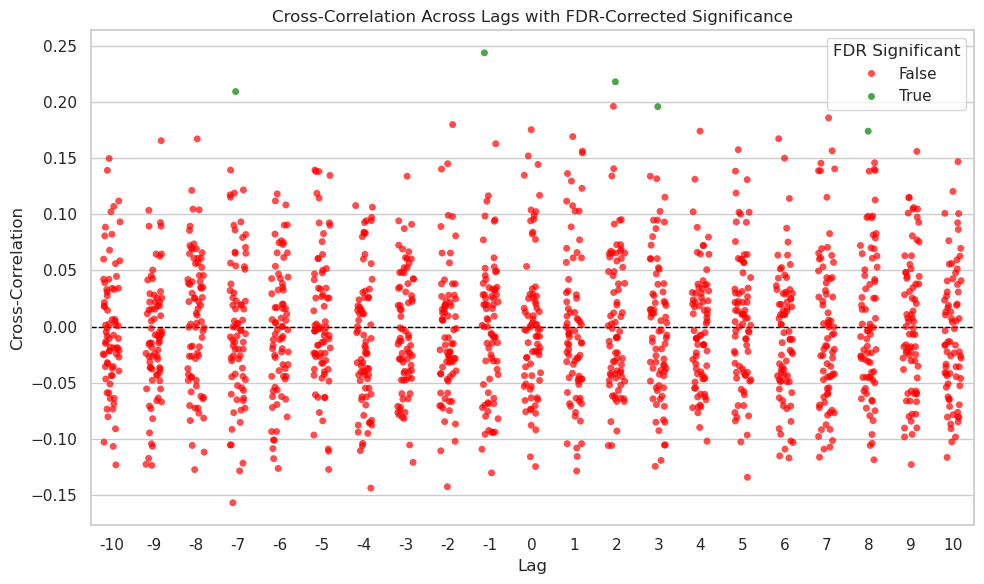

In [9]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot with x jitter and exact y-values
sns.stripplot(
    data=df,
    x="Lag",
    y="Correlation",
    hue="Significant",
    palette={True: "green", False: "red"},
    dodge=False,
    jitter=0.2,
    alpha=0.7
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Cross-Correlation Across Lags with FDR-Corrected Significance")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.legend(title="FDR Significant", loc="upper right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_359/2671377378.py:14: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_359/2671377378.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = df_plot.groupby("Lag", as_index=False)["Correlation"].mean()


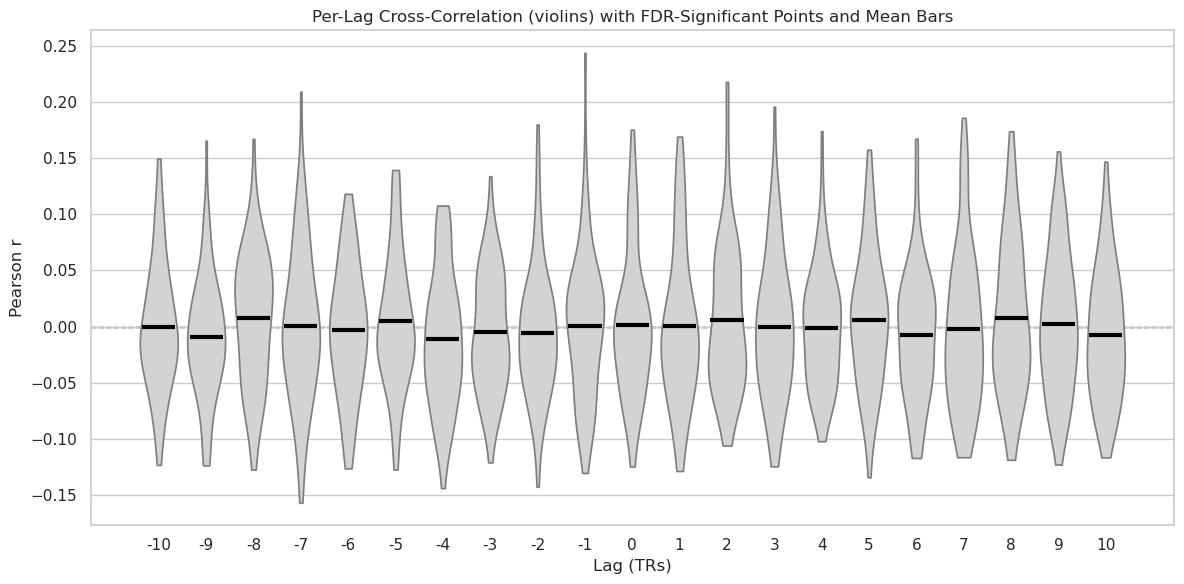

In [10]:
# Ensure Lag is ordered numerically
lag_order = sorted(df["Lag"].unique())
df_plot = df.copy()
df_plot["Lag"] = pd.Categorical(df_plot["Lag"], categories=lag_order, ordered=True)

# Subset to FDR-significant rows
sig_df = df_plot[df_plot["Significant"]].copy()

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = plt.gca()

# 1) Background violins (all subjects)
sns.violinplot(
    data=df_plot,
    x="Lag",
    y="Correlation",
    order=lag_order,
    inner=None,
    cut=0,
    scale="width",
    color="lightgray",
    ax=ax,
    zorder=1
)

# 2) Overlay only significant dots
#sns.stripplot(
#    data=sig_df,
#    x="Lag",
#    y="Correlation",
#    order=lag_order,
#    jitter=0.15,
#    alpha=0.95,
#    size=4.5,
#    color="tab:green",
#    ax=ax,
#    zorder=3
#)

# 3) Add mean bars (short horizontal lines at the mean per lag)
mean_df = df_plot.groupby("Lag", as_index=False)["Correlation"].mean()
xpos = {lag: i for i, lag in enumerate(lag_order)}  # map lag -> x position
bar_halfwidth = 0.35  # controls bar length across the violin

for _, row in mean_df.iterrows():
    x = xpos[row["Lag"]]
    y = row["Correlation"]
    ax.hlines(y, x - bar_halfwidth, x + bar_halfwidth, linewidth=3, color="black", zorder=4)

# Reference line at zero
ax.axhline(0, color="black", linestyle="--", linewidth=1, zorder=0)

ax.set_title("Per-Lag Cross-Correlation (violins) with FDR-Significant Points and Mean Bars")
ax.set_xlabel("Lag (TRs)")
ax.set_ylabel("Pearson r")

# No legend needed (only sig points are drawn)
leg = ax.get_legend()
if leg:
    leg.remove()

plt.tight_layout()
plt.show()


In [11]:
# --- Inputs assumed ---
# transitions_list: list of length S (subjects), each is a 1D np.array of 0/1 transitions, length T
# event_boundaries: 1D np.array length T with 0/1 (1 = boundary)
# -------------------------------------------------------------

# Parameters
pre_lag  = 0         # how many TRs BEFORE the boundary count as aligned
post_lag = 0         # how many TRs AFTER the boundary count as aligned
n_perm   = 1000
rng      = np.random.default_rng(42)

event = np.asarray(event_boundaries, dtype=int)
T = len(event)
S = len(transitions_list)
boundary_trs = np.where(event == 1)[0]              # indices of annotated boundaries

def window_hits_for_boundary(t0, trans_list, pre, post):
    """Return 0/1 hits across subjects for any transition in [t0-pre, t0+post]."""
    start = max(0, t0 - pre)
    end   = min(T, t0 + post) + 1  # slice end is exclusive
    hits = np.fromiter(
        (int(np.any(t[start:end])) for t in trans_list),
        dtype=int, count=S
    )
    return hits

# --- Observed proportion of subjects with a transition near each boundary ---
obs_prop = np.array([
    window_hits_for_boundary(t0, transitions_list, pre_lag, post_lag).mean()
    for t0 in boundary_trs
])

# --- Null via circular shifts of each subject independently ---
null_props = np.zeros((n_perm, len(boundary_trs)), dtype=float)

for p in range(n_perm):
    shifted = []
    for s in range(S):
        shift = rng.integers(1, T)  # exclude 0 shift
        shifted.append(np.roll(transitions_list[s], shift))
    null_props[p] = [
        window_hits_for_boundary(t0, shifted, pre_lag, post_lag).mean()
        for t0 in boundary_trs
    ]

# --- Per-boundary two-tailed p-values (against null mean) ---
null_mean = null_props.mean(axis=0)
obs_dev   = np.abs(obs_prop - null_mean)
null_dev  = np.abs(null_props - null_mean[None, :])
p_vals = (np.sum(null_dev >= obs_dev[None, :], axis=0) + 1) / (n_perm + 1)  # +1 for stability

# --- FDR across boundaries ---
rej, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

boundary_results = pd.DataFrame({
    "Boundary_TR": boundary_trs,
    "Observed_Prop": obs_prop,
    "Null_Mean": null_mean,
    "Effect": obs_prop - null_mean,
    "P_Value": p_vals,
    "P_Value_FDR": p_fdr,
    "Significant": rej
}).sort_values(["Significant", "P_Value"]).iloc[::-1]

print(boundary_results.head(10))


    Boundary_TR  Observed_Prop  Null_Mean    Effect   P_Value  P_Value_FDR  \
10          210       0.280000   0.145387  0.134613  0.000999     0.021978   
18          258       0.146667   0.143947  0.002720  1.000000     1.000000   
8           179       0.160000   0.146960  0.013040  0.900100     0.942962   
3            53       0.133333   0.144453 -0.011120  0.883117     0.942962   
20          270       0.133333   0.145933 -0.012600  0.865135     0.942962   
6           128       0.133333   0.145013 -0.011680  0.854146     0.942962   
21          272       0.160000   0.147280  0.012720  0.849151     0.942962   
9           208       0.160000   0.145947  0.014053  0.768232     0.942962   
1            23       0.133333   0.147520 -0.014187  0.767233     0.942962   
14          230       0.160000   0.143787  0.016213  0.749251     0.942962   

    Significant  
10         True  
18        False  
8         False  
3         False  
20        False  
6         False  
21        False

In [12]:
def eval_window(pre_lag, post_lag, transitions_list, event_boundaries, n_perm=1000, seed=42):
    rng = np.random.default_rng(seed)
    event = np.asarray(event_boundaries, dtype=int)
    T = len(event)
    S = len(transitions_list)
    boundary_trs = np.where(event == 1)[0]

    def window_hits_for_boundary(t0, trans_list):
        start = max(0, t0 - pre_lag)
        end   = min(T, t0 + post_lag) + 1
        return np.fromiter((int(np.any(t[start:end])) for t in trans_list), dtype=int, count=S)

    obs_prop = np.array([window_hits_for_boundary(t0, transitions_list).mean()
                         for t0 in boundary_trs])

    null_props = np.zeros((n_perm, len(boundary_trs)), float)
    for p in range(n_perm):
        shifted = [np.roll(t, rng.integers(1, T)) for t in transitions_list]  # keep counts, break alignment
        null_props[p] = [window_hits_for_boundary(t0, shifted).mean() for t0 in boundary_trs]

    null_mean = null_props.mean(axis=0)
    obs_dev   = np.abs(obs_prop - null_mean)
    null_dev  = np.abs(null_props - null_mean[None, :])
    p_vals    = (np.sum(null_dev >= obs_dev[None, :], axis=0) + 1) / (n_perm + 1)

    from statsmodels.stats.multitest import multipletests
    rej, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    summary = {
        "pre": pre_lag, "post": post_lag,
        "n_boundaries": len(boundary_trs),
        "n_sig": int(rej.sum()),
        "n_pos_sig": int(((obs_prop - null_mean > 0) & rej).sum()),
        "n_neg_sig": int(((obs_prop - null_mean < 0) & rej).sum()),
        "median_null": float(np.median(null_mean)),
    }
    return summary

windows = [(0,0), (0,1), (1,1), (0,2), (1,2), (3,3)]
summaries = [eval_window(a,b, transitions_list, event_boundaries, n_perm=500) for a,b in windows]
for s in summaries:
    print(s)

{'pre': 0, 'post': 0, 'n_boundaries': 22, 'n_sig': 2, 'n_pos_sig': 1, 'n_neg_sig': 1, 'median_null': 0.14565333333333325}
{'pre': 0, 'post': 1, 'n_boundaries': 22, 'n_sig': 1, 'n_pos_sig': 0, 'n_neg_sig': 1, 'median_null': 0.28423999999999994}
{'pre': 1, 'post': 1, 'n_boundaries': 22, 'n_sig': 1, 'n_pos_sig': 0, 'n_neg_sig': 1, 'median_null': 0.4072800000000001}
{'pre': 0, 'post': 2, 'n_boundaries': 22, 'n_sig': 1, 'n_pos_sig': 0, 'n_neg_sig': 1, 'median_null': 0.4070266666666672}
{'pre': 1, 'post': 2, 'n_boundaries': 22, 'n_sig': 1, 'n_pos_sig': 0, 'n_neg_sig': 1, 'median_null': 0.5085066666666666}
{'pre': 3, 'post': 3, 'n_boundaries': 22, 'n_sig': 3, 'n_pos_sig': 0, 'n_neg_sig': 3, 'median_null': 0.7031466666666666}


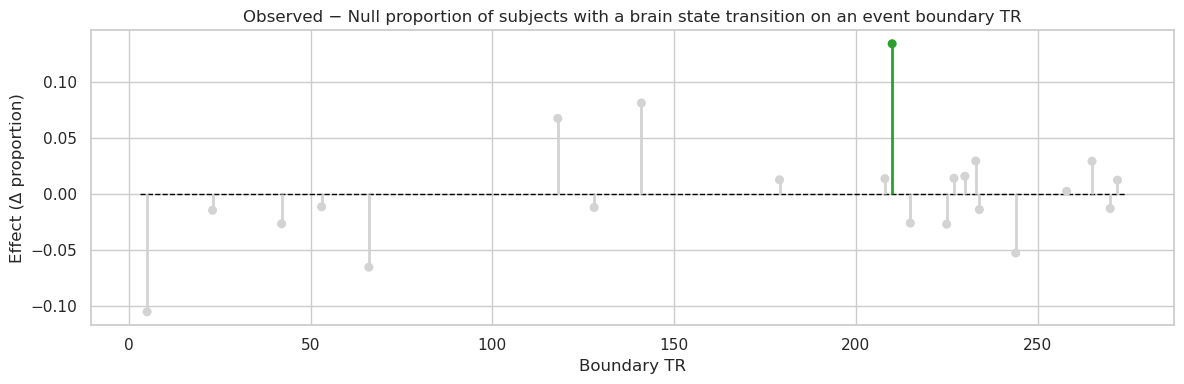

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume boundary_results is your DataFrame with columns:
# ["Boundary_TR","Observed_Prop","Null_Mean","Effect","P_Value","P_Value_FDR","Significant"]

br = boundary_results.copy().sort_values("Boundary_TR")
colors = np.where((br["Significant"]) & (br["Effect"]>0), "tab:green",
         np.where((br["Significant"]) & (br["Effect"]<0), "tab:red", "lightgray"))

plt.figure(figsize=(12, 4))
plt.hlines(0, br["Boundary_TR"].min()-2, br["Boundary_TR"].max()+2, linestyle="--", color="black", linewidth=1)
plt.vlines(br["Boundary_TR"], 0, br["Effect"], colors=colors, linewidth=2)
plt.scatter(br["Boundary_TR"], br["Effect"], color=colors, s=30, zorder=3)

plt.title("Observed − Null proportion of subjects with a brain state transition on an event boundary TR")
plt.xlabel("Boundary TR")
plt.ylabel("Effect (Δ proportion)")
plt.tight_layout()
plt.show()


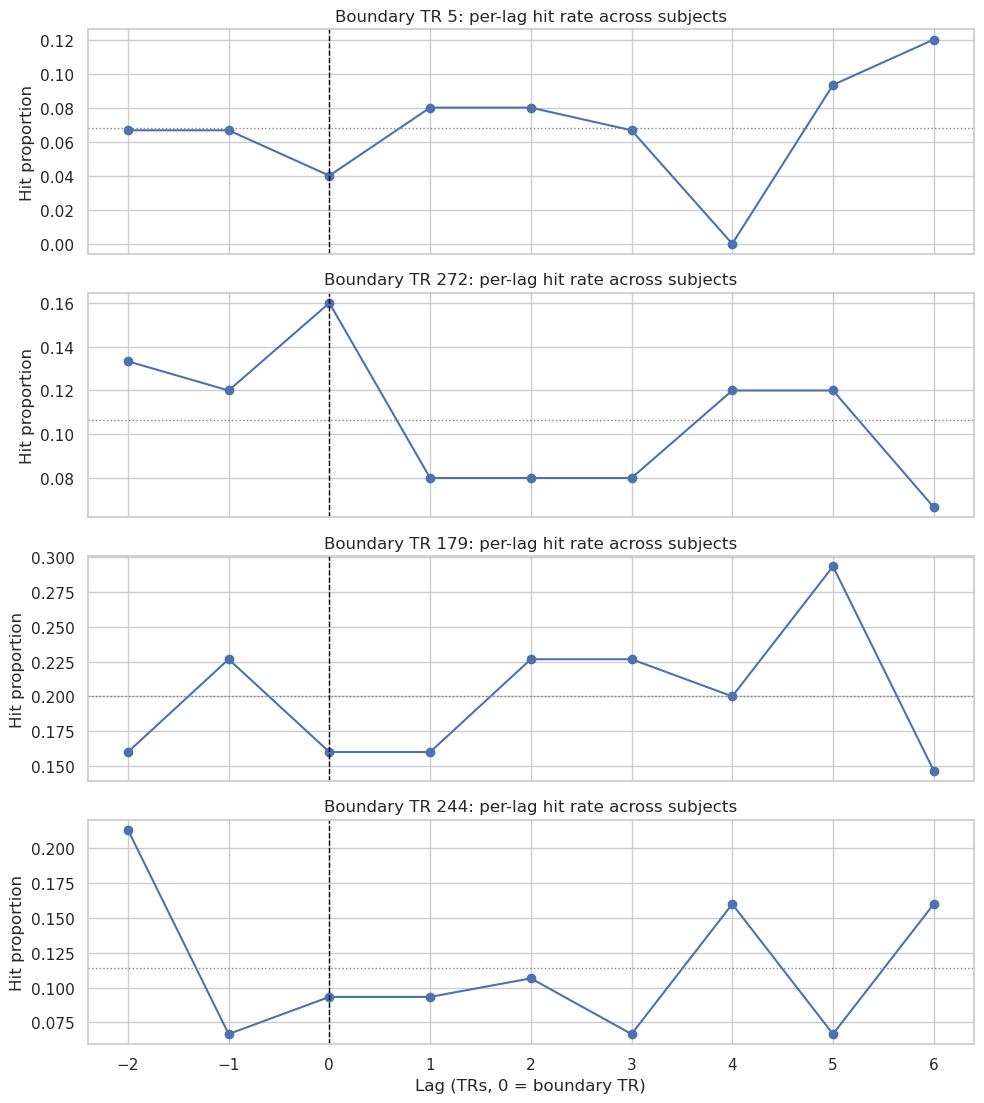

In [26]:
# Parameters for per-lag profile
lag_pre, lag_post = 2, 6   # e.g., −2..+6 TRs around boundary
lags = np.arange(-lag_pre, lag_post+1)

def per_lag_hit_rate(t0, trans_list, lags):
    T = len(trans_list[0])
    hits = []
    for L in lags:
        idx = t0 + L
        if 0 <= idx < T:
            hits.append(np.mean([t[idx] for t in trans_list]))
        else:
            hits.append(np.nan)
    return np.array(hits)

# Pick top K boundaries by |Effect| that are FDR-significant
top = (br[br["Significant"]]
       .assign(absEff=lambda d: d["Effect"].abs())
       .sort_values("absEff", ascending=False)
       .head(4))

fig, axes = plt.subplots(len(top), 1, figsize=(10, 2.8*len(top)), sharex=True)
if len(top) == 1: axes = [axes]

for ax, (_, row) in zip(axes, top.iterrows()):
    t0 = int(row["Boundary_TR"])
    rates = per_lag_hit_rate(t0, transitions_list, lags)
    ax.plot(lags, rates, marker="o")
    ax.axhline(np.nanmean(rates), color="gray", linestyle=":", linewidth=1)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_title(f"Boundary TR {t0}: per-lag hit rate across subjects")
    ax.set_ylabel("Hit proportion")
axes[-1].set_xlabel("Lag (TRs, 0 = boundary TR)")
plt.tight_layout()
plt.show()
